In [1]:
import numpy as np
import string
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt


In [3]:
df_train = pd.read_csv('qald-7-train.csv')
df_test = pd.read_csv('qald-7-test.csv')

In [4]:
df_train.head()

,questions,lang
0,When was the Battle of Gettysburg?,en
1,Quando foi a batalha de Gettysburg?,pt_BR
2,Wann fand die Schlacht von Gettysburg statt?,de
3,¿Cuándo tuvo lugar la batalla de Gettysburg?,es
4,Quando ha avuto luogo la battaglia di Gettysburg?,it


In [5]:
df_train.shape

(1983, 2)

In [6]:
df_test.head()

,questions,lang
0,Are there any castles in the United States?,en
1,NaN,fa
2,Gibt es irgendwelche Schlösser in den Vereinig...,de
3,NaN,es
4,Ci sono castelli negli Stati Uniti?,it


In [7]:
df_test=df_test.dropna(subset=['questions'])

In [8]:
df_test.shape

(172, 2)

In [9]:
df_train["lang"].unique()

array(['en', 'pt_BR', 'de', 'es', 'it', 'fr', 'nl', 'hi_IN', 'ro', 'fa'],
      dtype=object)

In [10]:
df_test["lang"].unique()

array(['en', 'de', 'it', 'fr'], dtype=object)

In [11]:
# English, German, Spanish, Italian, French, Dutch, Romanian
# {'en': 0, 'de': 1, 'es': 2, 'it': 3, 'fr': 4, 'nl': 5, 'ro': 6}

In [12]:
columns = ['pt_BR','hi_IN','fa']
for col in columns:
    df_train = df_train[df_train.lang!=col]
    df_test = df_test[df_test.lang!=col]

In [13]:
def preprocess(text):
        
    preprocessed_text = text.lower().replace('-', ' ')
    
    translation_table = str.maketrans('\n', ' ', string.punctuation+string.digits)
    
    preprocessed_text = preprocessed_text.translate(translation_table)
        
    return preprocessed_text

In [14]:
df_test=df_test.dropna(subset=['questions'])

In [15]:
df_train=df_train.dropna(subset=['questions'])

In [16]:
df_train['questions'] = [preprocess(text) for text in df_train['questions'].values]

In [17]:
df_test['questions'] = [preprocess(text) for text in df_test['questions'].values]

In [18]:
# df_train.head()

In [19]:
# subwords

In [20]:
df = pd.concat([df_test, df_train], ignore_index=True)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['questions'],
    df['lang'],
    test_size=0.20,
    shuffle=True,
    stratify=df['lang'],
    random_state=7
)

In [22]:
# taken from https://arxiv.org/abs/1508.07909

import re, collections
from collections import defaultdict
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [23]:
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [24]:
X_train

22      dammi tutti i presidenti americani degli ultim...
1275                         quanto è alto michael jordan
930       combien de groupes ethniques vivent en slovénie
1443       kaurismäki ha mai vinto il grand prix a cannes
1162                        qual è il prefisso di berlino
                              ...                        
1544        quale papa ha fondato la televisione vaticana
967     cine este cel mai tânăr jucător din premier le...
454                      wieviele menschen leben in polen
1582            how many languages are spoken in colombia
208                         quanto è costato pulp fiction
Name: questions, Length: 1304, dtype: object

In [25]:
vocab = get_vocab(X_train)

In [26]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [27]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [28]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [29]:
# pkl.dump(merge_ordered, open('Data/Auxiliary/merge_ordered.pkl', 'wb'))

In [30]:
def split_into_subwords(text):
    merges = merge_ordered
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [31]:
split_into_subwords('My name is Oshara')

'am is ar'

In [32]:
X_train = [split_into_subwords(text) for text in X_train.values]

In [33]:
X_test = [split_into_subwords(text) for text in X_test.values]

In [34]:
vectorizer = CountVectorizer()

In [35]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [36]:
X_train

<1304x72 sparse matrix of type '<class 'numpy.int64'>'
	with 13039 stored elements in Compressed Sparse Row format>

In [37]:
naive_classifier = MultinomialNB(fit_prior=False,alpha=0.01)
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.01, fit_prior=False)

In [38]:
predictions = naive_classifier.predict(X_test)

In [39]:
# 0.7638036809815951

In [40]:
accuracy_score(y_test, predictions)

0.7638036809815951

In [41]:
# y_train.unique()

In [42]:
# y_test.unique()

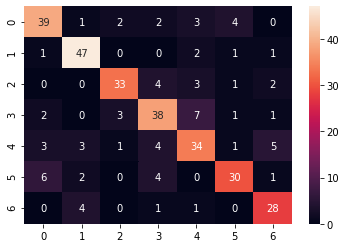

In [43]:
cm = confusion_matrix(y_test,predictions)
sns.heatmap(cm,annot=True,fmt="d");